In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage import io
import pickle
from sklearn.utils import class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 10
DATA_DIR = "/content/drive/MyDrive/sample images"
NUM_TRAIN_IMAGES = 3000
NUM_VAL_IMAGES = 600

train_images = sorted(glob(os.path.join(DATA_DIR, "samples_train/train images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "combinedmasks/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "sample_val/v/*")))[:NUM_VAL_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "combinedmasks_val/*")))[:NUM_VAL_IMAGES]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
# Define the weights for each class
class_weights = tf.constant([0.95, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  

# Define the custom loss function
def weighted_sparse_categorical_crossentropy(class_weights):
  def tf_loss(y_true, y_pred):
    class_weights_int = tf.cast(class_weights, tf.int32)
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
    y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    weights = tf.gather(class_weights_int, y_true_flat)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_flat, y_pred_flat, from_logits=True)
    weighted_loss = tf.multiply(loss, tf.cast(weights, tf.float32))
    return tf.reduce_mean(weighted_loss)

  return tf_loss

In [ ]:
with tf.device('/device:GPU:0'):
  model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
  model.summary()
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      loss=weighted_sparse_categorical_crossentropy(class_weights),
      metrics=["accuracy"],
  )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=4)

Epoch 1/4
375/375 [==============================] - 297s 709ms/step - loss: 0.2698 - accuracy: 0.0684 - val_loss: 0.2467 - val_accuracy: 0.0762
Epoch 2/4
375/375 [==============================] - 265s 706ms/step - loss: 0.2460 - accuracy: 0.0674 - val_loss: 0.2506 - val_accuracy: 0.0629
Epoch 3/4
375/375 [==============================] - 265s 706ms/step - loss: 0.2426 - accuracy: 0.0661 - val_loss: 6.6458 - val_accuracy: 0.0586
Epoch 4/4
375/375 [==============================] - 264s 704ms/step - loss: 0.2413 - accuracy: 0.0677 - val_loss: 0.2593 - val_accuracy: 0.0477


In [ ]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [ ]:
arr = read_image(val_images[0])

In [ ]:
test = infer(model,arr)

1/1 [==============================] - 0s 29ms/step


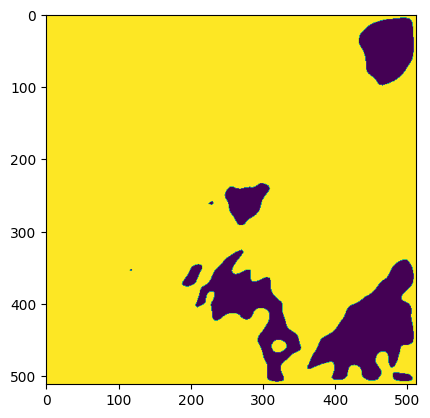

In [ ]:
plt.imshow(test)

In [ ]:
np.unique(test)

array([4, 9])

In [ ]:
arr2 = io.imread(val_masks[0])

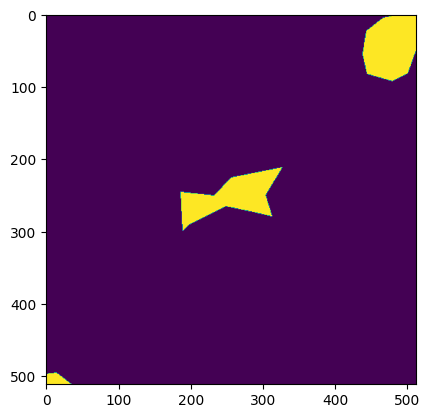

In [ ]:
plt.imshow(arr2)

In [ ]:
arr3 = io.imread(val_masks[400])

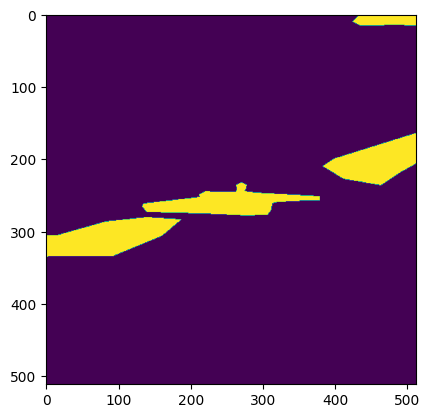

In [ ]:
plt.imshow(arr3)

In [ ]:
arr3 = read_image(val_images[18])

In [ ]:
test = infer(model,arr3)

1/1 [==============================] - 0s 30ms/step


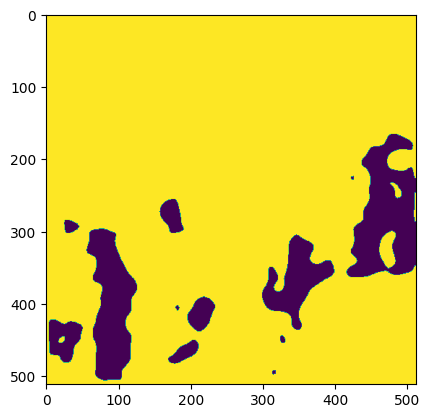

In [ ]:
plt.imshow(test)

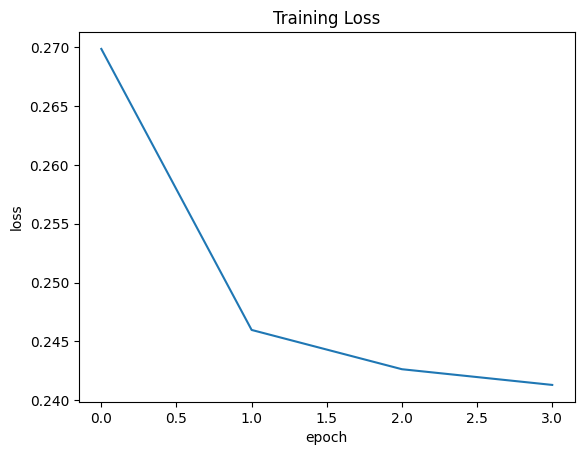

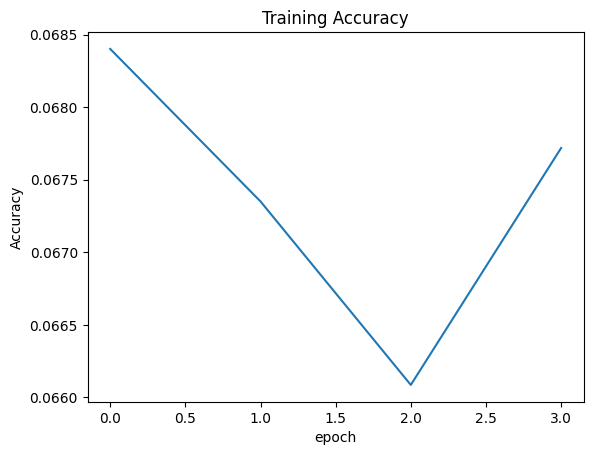

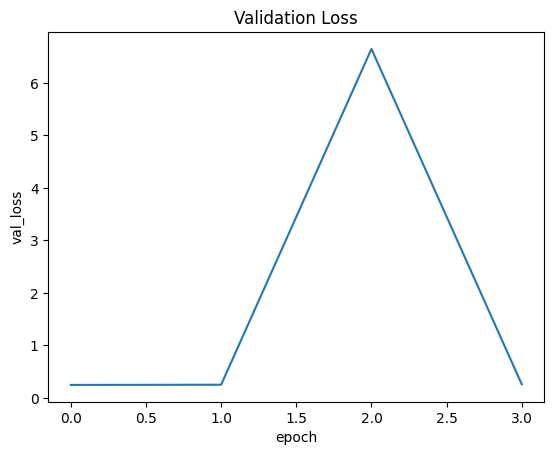

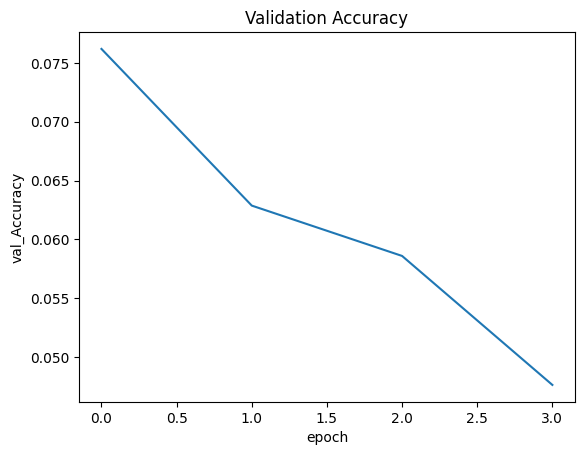

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_Accuracy")
plt.xlabel("epoch")
plt.show()